In [1]:
# import các thư viện
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# mapping
labels = {
    "Others": 0,
    "Honda": 1,
    "Suzuki": 2,
    "Yamaha": 3,
    "VinFast": 4
}
reverse_map_labels = {
    0: "Others",
    1: "Honda",
    2: "Suzuki",
    3: "Yamaha",
    4: "VinFast"
}

In [4]:
path = "/content/drive/MyDrive/Public"
output_dir = 'MotocycleDataset.csv'
d1 = []
error = pd.read_csv('/content/invalid_image_paths(1).csv')
error_paths = error.iloc[:, 0].unique().tolist()

In [5]:
def read_path(path, out_put):
    data = []
    supported_formats = ['jpg', 'png', 'jpeg']

    for label in os.listdir(path):
        if label in labels:
            y = labels[label]
            i = 0
            new_path = os.path.join(path, label)
            if os.listdir(new_path):
                for img in os.listdir(new_path):
                    if i == 1001: break
                    if any(img.lower().endswith(fmt) for fmt in supported_formats):
                        path_img = os.path.join(label, img)
                        if path_img not in error_paths:
                          data.append((path_img, int(y)))
                          i += 1

    df = pd.DataFrame(data, columns=['ImageFullPath', 'CategoryID'])
    df.to_csv(out_put, sep=',', index=False)
    return df

In [6]:
# # create file MotocycleDataset.csv
# def read_path1(path,out_put):
#   data = []
#   for label in os.listdir(path):
#     if label in labels:
#         y = labels[label]
#         new_path = os.path.join(path,label)
#         if os.listdir(new_path):
#           for img in os.listdir(new_path):
#                 type_img = img.split('.')[-1]

#                 if type_img == 'jfif' or type_img == 'webp' or type_img == 'jpe' or type_img == 'gif' or type_img == 'avif':
#                   path_img = os.path.join(label,img)
#                   d1.append(path_img)
#     #           if img.endswith('jpg') or img.endswith('jpeg') or img.endswith('png'):
#     #             path_img = os.path.join(label,img)
#     #             data.append((path_img,int(y)))
#     # df = pd.DataFrame(data,columns = ['ImageFullPath','CategoryID'])
#     # df.to_csv(out_put, sep=',',index=False)
#     # return d1

In [7]:
a = read_path(path,output_dir)
print(len(a))

5005


So sánh thời gian đọc ảnh của pil và cv2

In [8]:
path1 = "/content/drive/MyDrive/Public"
img_path = "/content/MotocycleDataset.csv"

In [9]:
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2

In [10]:

from zipfile import ZipFile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sklearn.model_selection import train_test_split
from collections import Counter


In [11]:
data = pd.read_csv(img_path)
img = data['ImageFullPath']
label = data['CategoryID']
image = [os.path.join(path1, i) for i in img]

In [12]:
len(image)

5005

In [13]:
trainX, testX, trainY, testY = train_test_split(image, label, test_size=0.3, random_state=30)
train_label_count = Counter(trainY)
test_label_count = Counter(testY)

In [14]:
testX, valX, testY, valY = train_test_split(testX, testY, test_size=0.3, random_state=30)

In [15]:
train_label_count

Counter({3: 705, 1: 720, 2: 703, 0: 689, 4: 686})

In [16]:
test_label_count

Counter({4: 315, 1: 281, 3: 296, 2: 298, 0: 312})

In [17]:
print(len(trainX))
print(len(testX))
print(len(valX))

3503
1051
451


In [18]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [19]:
class CustomDataset(Dataset):
    def __init__(self, img_paths, labels, num_classes, transform=None):
        self.img_paths = img_paths
        self.labels = np.array(labels)  # Convert labels to numpy array
        self.num_classes = num_classes
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]  # Retrieve label as integer

        img_cv2 = cv2.imread(img_path)
        img_cv2_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
        img_pil_from_cv2 = Image.fromarray(img_cv2_rgb)

        if self.transform:
            img_pil_from_cv2 = self.transform(img_pil_from_cv2)

        return img_pil_from_cv2, torch.tensor(label, dtype=torch.long)

In [20]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224, interpolation=Image.BILINEAR),  # Resize to 384x384
        transforms.CenterCrop(224),  # Center crop to 384x384
        transforms.RandomHorizontalFlip(),  # Random horizontal flip for augmentation
        transforms.ToTensor(),  # Convert PIL image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats

    ]),
    'val': transforms.Compose([
        transforms.Resize(224, interpolation=Image.BILINEAR),  # Resize to 384x384
        transforms.CenterCrop(224),  # Center crop to 384x384
        transforms.ToTensor(),  # Convert PIL image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats

    ]),
    'test': transforms.Compose([
        transforms.Resize(384, interpolation=Image.BILINEAR),  # Resize to 384x384
        transforms.CenterCrop(384),  # Center crop to 384x384
        transforms.ToTensor(),  # Convert PIL image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats

    ]),
}

In [21]:
from torch.utils.data import Dataset, DataLoader

In [22]:
train_set = CustomDataset(trainX, trainY, num_classes = 5, transform=data_transforms['train'])
val_set = CustomDataset(valX,valY, num_classes = 5, transform=data_transforms['val'])
test_set = CustomDataset(testX,testY, num_classes = 5, transform=data_transforms['test'])

train_loader = DataLoader(train_set, batch_size=16, shuffle=True, pin_memory=True,num_workers=4)
val_loader = DataLoader(val_set, batch_size=16, shuffle=True, pin_memory=True,num_workers= 4)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False,pin_memory=True,num_workers= 4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [23]:
for i in test_loader:
  a,b = i
  print(a)
  print(b)
  break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tensor([[[[-1.2959, -1.2959, -1.2959,  ...,  0.1254, -0.0287, -0.1657],
          [-1.2959, -1.2617, -1.2788,  ...,  0.2796,  0.0741, -0.0287],
          [-1.2617, -1.2445, -1.2274,  ...,  0.4508,  0.2453,  0.1083],
          ...,
          [ 0.2967,  0.1426, -0.2513,  ..., -0.3369, -0.3027, -0.3027],
          [ 0.2967,  0.2967,  0.2111,  ..., -0.3027, -0.2856, -0.2856],
          [ 0.2796,  0.2967,  0.2967,  ..., -0.3027, -0.2856, -0.2856]],

         [[-1.0203, -1.0203, -1.0203,  ..., -0.1099, -0.2500, -0.3550],
          [-0.9853, -0.9678, -0.9678,  ...,  0.0651, -0.1099, -0.1800],
          [-0.9503, -0.9328, -0.8978,  ...,  0.2402,  0.0651, -0.0399],
          ...,
          [ 0.4328,  0.2752, -0.1275,  ..., -0.1800, -0.1625, -0.1625],
          [ 0.4328,  0.4328,  0.3452,  ..., -0.1625, -0.1450, -0.1450],
          [ 0.4153,  0.4328,  0.4328,  ..., -0.1625, -0.1450, -0.1450]],

         [[-0.8110, -0.7936, -0.7936,  ..., -0.1312, -0.2532, -0.3055],
          [-0.7761, -0.7413, -

In [24]:
print(len(train_loader.dataset))
print(len(test_loader.dataset))

3503
1051


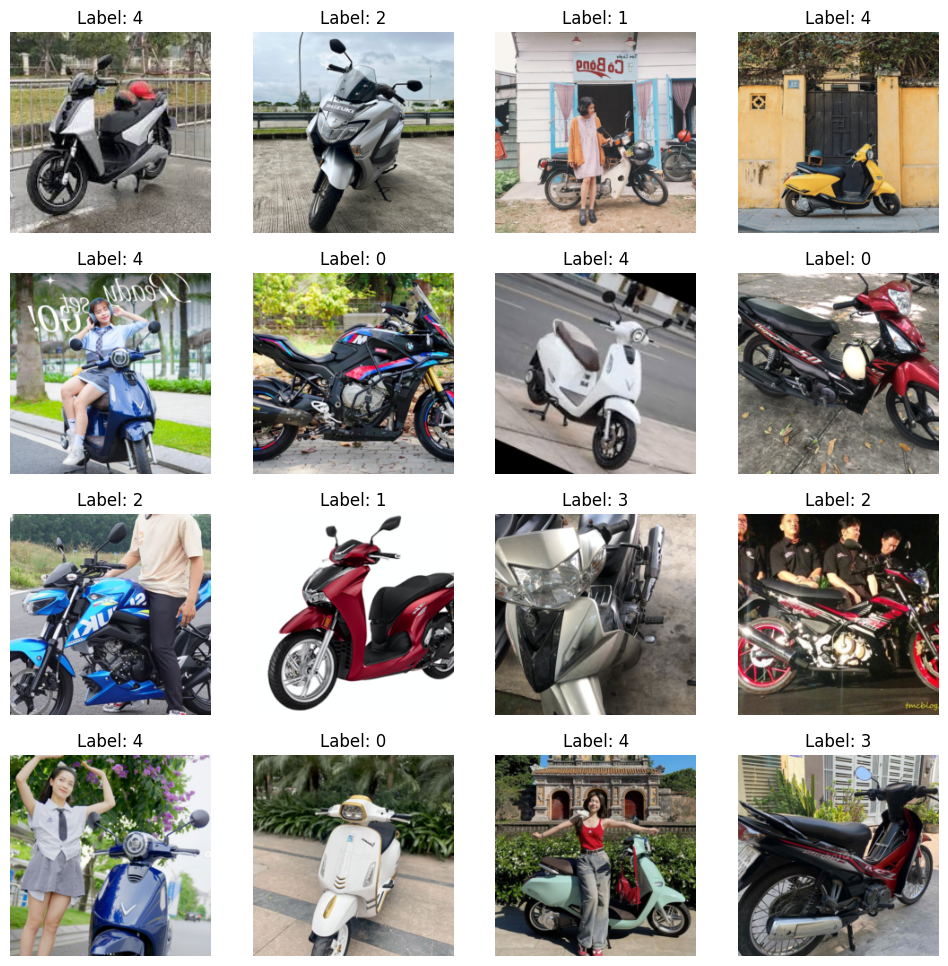

In [25]:
def show_batch_images(images, labels, mean, std, max_images=16):
    # Ensure mean and std are numpy arrays
    mean = np.array(mean)
    std = np.array(std)

    plt.figure(figsize=(12, 12))
    for i in range(min(len(images), max_images)):
        image = images[i].numpy().transpose((1, 2, 0))  # Transpose tensor from (C, H, W) to (H, W, C)

        # Denormalize
        image = std * image + mean
        image = np.clip(image, 0, 1)  # Ensure values are in [0, 1]

        plt.subplot(4, 4, i + 1)  # 4 rows and 4 columns
        plt.imshow(image)
        plt.title(f'Label: {labels[i].item()}')
        plt.axis('off')
    plt.show()

# Example usage:
# Assuming you have a batch of images and labels
batch_images, batch_labels = next(iter(train_loader))  # Replace data_loader with your actual DataLoader
show_batch_images(batch_images, batch_labels, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [26]:

from tempfile import TemporaryDirectory
import torch.optim as optim
import time


In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
device

device(type='cuda')

In [29]:
import copy

In [30]:
!pip install tqdm

In [31]:
from tqdm import tqdm

In [32]:
def plot_training_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
    # Ensure that the histories are converted to NumPy arrays if they are tensors
    if isinstance(train_loss_history, torch.Tensor):
        train_loss_history = train_loss_history.detach().cpu().numpy()
    if isinstance(val_loss_history, torch.Tensor):
        val_loss_history = val_loss_history.detach().cpu().numpy()
    if isinstance(train_acc_history, torch.Tensor):
        train_acc_history = train_acc_history.detach().cpu().numpy()
    if isinstance(val_acc_history, torch.Tensor):
        val_acc_history = val_acc_history.detach().cpu().numpy()

    # Vẽ biểu đồ loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Vẽ biểu đồ accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

In [33]:
import torchvision.models as models
from torch.optim import lr_scheduler

In [36]:
model_ft = torchvision.models.regnet_y_128gf(weights='RegNet_Y_128GF_Weights.IMAGENET1K_SWAG_LINEAR_V1')

# Freeze all layers except the last fully connected layer
for param in model_ft.parameters():
    param.requires_grad = False

# Unfreeze the last fully connected layer (access 'fc' directly)
for param in model_ft.fc.parameters():
    param.requires_grad = True


# Replace the last fully connected layer with a new one
num_ftrs = model_ft.fc.in_features
model_ft.classifier = nn.Sequential(  # Replace the classifier attribute
    nn.Linear(num_ftrs, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(1024, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 5)  # Assuming you have 5 classes
)

# Move model to device (GPU if available)
model_ft = model_ft.to(device)

# Print the modified model architecture
print(model_ft)

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(528, 528, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

In [37]:
criterion = nn.CrossEntropyLoss()

# Define optimizer (SGD with momentum)
optimizer = optim.AdamW(model_ft.parameters(), lr=0.01, weight_decay=0.01)

# Define learning rate scheduler (decay LR by a factor of 0.1 every 7 epochs)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [38]:
print(model_ft)

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(528, 528, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

In [45]:
import torch
import time
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()
    best_model_params_path = '/content/drive/MyDrive/dataa/regnet.pt'
    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            image_counter = 0

            for inputs, labels in tqdm(dataloader, desc=f'{phase} {epoch+1}/{num_epochs}'):
                inputs = inputs.to(device)
                labels = labels.to(device)
                image_counter += len(inputs)
                if image_counter % 200 == 0:
                    print(f'Processed {image_counter} images in phase: {phase}, epoch: {epoch+1}')

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(torch.load(best_model_params_path))

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history



In [46]:
model_ft, train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(model_ft, criterion,optimizer,exp_lr_scheduler, num_epochs=15)

Epoch 1/15
------------------------------


train 1/15:  11%|█         | 24/219 [01:14<08:03,  2.48s/it]

Processed 400 images in phase: train, epoch: 1


train 1/15:  22%|██▏       | 49/219 [02:22<07:02,  2.49s/it]

Processed 800 images in phase: train, epoch: 1


train 1/15:  34%|███▍      | 74/219 [03:33<06:24,  2.65s/it]

Processed 1200 images in phase: train, epoch: 1


train 1/15:  45%|████▌     | 99/219 [04:41<04:37,  2.31s/it]

Processed 1600 images in phase: train, epoch: 1


train 1/15:  57%|█████▋    | 124/219 [05:47<02:56,  1.86s/it]

Processed 2000 images in phase: train, epoch: 1


train 1/15:  68%|██████▊   | 149/219 [07:02<05:05,  4.36s/it]

Processed 2400 images in phase: train, epoch: 1


train 1/15:  79%|███████▉  | 174/219 [08:04<02:05,  2.79s/it]

Processed 2800 images in phase: train, epoch: 1


train 1/15:  91%|█████████ | 199/219 [09:08<00:49,  2.47s/it]

Processed 3200 images in phase: train, epoch: 1


train 1/15: 100%|██████████| 219/219 [10:00<00:00,  2.74s/it]


train Loss: 6.3678 Acc: 0.4902


val 1/15:  83%|████████▎ | 24/29 [01:12<00:08,  1.69s/it]

Processed 400 images in phase: val, epoch: 1


val 1/15: 100%|██████████| 29/29 [01:24<00:00,  2.91s/it]


val Loss: 5.3155 Acc: 0.6275

Epoch 2/15
------------------------------


train 2/15:  11%|█         | 24/219 [00:24<02:00,  1.62it/s]

Processed 400 images in phase: train, epoch: 2


train 2/15:  22%|██▏       | 49/219 [00:46<01:31,  1.85it/s]

Processed 800 images in phase: train, epoch: 2


train 2/15:  34%|███▍      | 74/219 [01:07<01:21,  1.78it/s]

Processed 1200 images in phase: train, epoch: 2


train 2/15:  45%|████▌     | 99/219 [01:26<01:00,  1.97it/s]

Processed 1600 images in phase: train, epoch: 2


train 2/15:  57%|█████▋    | 124/219 [01:42<00:44,  2.11it/s]

Processed 2000 images in phase: train, epoch: 2


train 2/15:  68%|██████▊   | 149/219 [02:03<00:42,  1.63it/s]

Processed 2400 images in phase: train, epoch: 2


train 2/15:  79%|███████▉  | 174/219 [02:22<00:21,  2.05it/s]

Processed 2800 images in phase: train, epoch: 2


train 2/15:  91%|█████████ | 199/219 [02:42<00:11,  1.71it/s]

Processed 3200 images in phase: train, epoch: 2


train 2/15: 100%|██████████| 219/219 [02:58<00:00,  1.23it/s]


train Loss: 4.5965 Acc: 0.6660


val 2/15:  83%|████████▎ | 24/29 [00:21<00:02,  2.14it/s]

Processed 400 images in phase: val, epoch: 2


val 2/15: 100%|██████████| 29/29 [00:23<00:00,  1.24it/s]


val Loss: 7.0558 Acc: 0.6430

Epoch 3/15
------------------------------


train 3/15:  11%|█         | 24/219 [00:28<04:13,  1.30s/it]

Processed 400 images in phase: train, epoch: 3


train 3/15:  22%|██▏       | 49/219 [00:52<02:20,  1.21it/s]

Processed 800 images in phase: train, epoch: 3


train 3/15:  34%|███▍      | 74/219 [01:06<01:10,  2.05it/s]

Processed 1200 images in phase: train, epoch: 3


train 3/15:  45%|████▌     | 99/219 [01:29<03:08,  1.57s/it]

Processed 1600 images in phase: train, epoch: 3


train 3/15:  57%|█████▋    | 124/219 [01:50<02:15,  1.42s/it]

Processed 2000 images in phase: train, epoch: 3


train 3/15:  68%|██████▊   | 149/219 [02:04<00:33,  2.11it/s]

Processed 2400 images in phase: train, epoch: 3


train 3/15:  79%|███████▉  | 174/219 [02:23<00:21,  2.09it/s]

Processed 2800 images in phase: train, epoch: 3


train 3/15:  91%|█████████ | 199/219 [02:42<00:17,  1.13it/s]

Processed 3200 images in phase: train, epoch: 3


train 3/15: 100%|██████████| 219/219 [02:58<00:00,  1.22it/s]


train Loss: 3.9152 Acc: 0.7279


val 3/15:  83%|████████▎ | 24/29 [00:19<00:02,  1.99it/s]

Processed 400 images in phase: val, epoch: 3


val 3/15: 100%|██████████| 29/29 [00:22<00:00,  1.28it/s]


val Loss: 5.6579 Acc: 0.6962

Epoch 4/15
------------------------------


train 4/15:  11%|█         | 24/219 [00:24<02:04,  1.56it/s]

Processed 400 images in phase: train, epoch: 4


train 4/15:  22%|██▏       | 49/219 [00:48<02:33,  1.10it/s]

Processed 800 images in phase: train, epoch: 4


train 4/15:  34%|███▍      | 74/219 [01:08<01:26,  1.67it/s]

Processed 1200 images in phase: train, epoch: 4


train 4/15:  45%|████▌     | 99/219 [01:27<00:58,  2.04it/s]

Processed 1600 images in phase: train, epoch: 4


train 4/15:  57%|█████▋    | 124/219 [01:44<01:05,  1.45it/s]

Processed 2000 images in phase: train, epoch: 4


train 4/15:  68%|██████▊   | 149/219 [02:05<00:35,  1.96it/s]

Processed 2400 images in phase: train, epoch: 4


train 4/15:  79%|███████▉  | 174/219 [02:25<00:25,  1.78it/s]

Processed 2800 images in phase: train, epoch: 4


train 4/15:  91%|█████████ | 199/219 [02:43<00:10,  1.99it/s]

Processed 3200 images in phase: train, epoch: 4


train 4/15: 100%|██████████| 219/219 [02:58<00:00,  1.23it/s]


train Loss: 3.1855 Acc: 0.7745


val 4/15:  83%|████████▎ | 24/29 [00:21<00:02,  1.92it/s]

Processed 400 images in phase: val, epoch: 4


val 4/15: 100%|██████████| 29/29 [00:23<00:00,  1.21it/s]


val Loss: 9.8143 Acc: 0.6630

Epoch 5/15
------------------------------


train 5/15:  11%|█         | 24/219 [00:20<01:48,  1.80it/s]

Processed 400 images in phase: train, epoch: 5


train 5/15:  22%|██▏       | 49/219 [00:37<01:33,  1.82it/s]

Processed 800 images in phase: train, epoch: 5


train 5/15:  34%|███▍      | 74/219 [00:58<01:21,  1.78it/s]

Processed 1200 images in phase: train, epoch: 5


train 5/15:  45%|████▌     | 99/219 [01:19<01:12,  1.66it/s]

Processed 1600 images in phase: train, epoch: 5


train 5/15:  57%|█████▋    | 124/219 [01:37<00:59,  1.60it/s]

Processed 2000 images in phase: train, epoch: 5


train 5/15:  68%|██████▊   | 149/219 [01:54<00:40,  1.71it/s]

Processed 2400 images in phase: train, epoch: 5


train 5/15:  79%|███████▉  | 174/219 [02:13<00:25,  1.77it/s]

Processed 2800 images in phase: train, epoch: 5


train 5/15:  91%|█████████ | 199/219 [02:32<00:12,  1.66it/s]

Processed 3200 images in phase: train, epoch: 5


train 5/15: 100%|██████████| 219/219 [02:47<00:00,  1.31it/s]


train Loss: 3.1615 Acc: 0.7868


val 5/15:  83%|████████▎ | 24/29 [00:21<00:03,  1.34it/s]

Processed 400 images in phase: val, epoch: 5


val 5/15: 100%|██████████| 29/29 [00:23<00:00,  1.23it/s]


val Loss: 8.3554 Acc: 0.6785

Epoch 6/15
------------------------------


train 6/15:  11%|█         | 24/219 [00:20<02:25,  1.34it/s]

Processed 400 images in phase: train, epoch: 6


train 6/15:  22%|██▏       | 49/219 [00:39<02:16,  1.25it/s]

Processed 800 images in phase: train, epoch: 6


train 6/15:  34%|███▍      | 74/219 [00:58<01:18,  1.85it/s]

Processed 1200 images in phase: train, epoch: 6


train 6/15:  45%|████▌     | 99/219 [01:15<01:16,  1.57it/s]

Processed 1600 images in phase: train, epoch: 6


train 6/15:  57%|█████▋    | 124/219 [01:36<00:59,  1.59it/s]

Processed 2000 images in phase: train, epoch: 6


train 6/15:  68%|██████▊   | 149/219 [01:55<00:40,  1.74it/s]

Processed 2400 images in phase: train, epoch: 6


train 6/15:  79%|███████▉  | 174/219 [02:13<00:27,  1.66it/s]

Processed 2800 images in phase: train, epoch: 6


train 6/15:  91%|█████████ | 199/219 [02:28<00:12,  1.62it/s]

Processed 3200 images in phase: train, epoch: 6


train 6/15: 100%|██████████| 219/219 [02:43<00:00,  1.34it/s]


train Loss: 1.5619 Acc: 0.8607


val 6/15:  83%|████████▎ | 24/29 [00:20<00:04,  1.22it/s]

Processed 400 images in phase: val, epoch: 6


val 6/15: 100%|██████████| 29/29 [00:23<00:00,  1.23it/s]


val Loss: 6.0649 Acc: 0.7162

Epoch 7/15
------------------------------


train 7/15:  11%|█         | 24/219 [00:28<02:57,  1.10it/s]

Processed 400 images in phase: train, epoch: 7


train 7/15:  22%|██▏       | 49/219 [00:51<01:46,  1.60it/s]

Processed 800 images in phase: train, epoch: 7


train 7/15:  34%|███▍      | 74/219 [01:10<01:41,  1.42it/s]

Processed 1200 images in phase: train, epoch: 7


train 7/15:  45%|████▌     | 99/219 [01:27<01:15,  1.59it/s]

Processed 1600 images in phase: train, epoch: 7


train 7/15:  57%|█████▋    | 124/219 [01:44<00:52,  1.81it/s]

Processed 2000 images in phase: train, epoch: 7


train 7/15:  68%|██████▊   | 149/219 [02:03<00:50,  1.37it/s]

Processed 2400 images in phase: train, epoch: 7


train 7/15:  79%|███████▉  | 174/219 [02:24<00:42,  1.06it/s]

Processed 2800 images in phase: train, epoch: 7


train 7/15:  91%|█████████ | 199/219 [02:42<00:11,  1.68it/s]

Processed 3200 images in phase: train, epoch: 7


train 7/15: 100%|██████████| 219/219 [02:57<00:00,  1.23it/s]


train Loss: 1.0089 Acc: 0.8941


val 7/15:  83%|████████▎ | 24/29 [00:21<00:03,  1.45it/s]

Processed 400 images in phase: val, epoch: 7


val 7/15: 100%|██████████| 29/29 [00:23<00:00,  1.22it/s]


val Loss: 5.8223 Acc: 0.7295

Epoch 8/15
------------------------------


train 8/15:  11%|█         | 24/219 [00:22<02:35,  1.26it/s]

Processed 400 images in phase: train, epoch: 8


train 8/15:  22%|██▏       | 49/219 [00:44<01:38,  1.73it/s]

Processed 800 images in phase: train, epoch: 8


train 8/15:  34%|███▍      | 74/219 [01:06<01:15,  1.91it/s]

Processed 1200 images in phase: train, epoch: 8


train 8/15:  45%|████▌     | 99/219 [01:25<00:59,  2.00it/s]

Processed 1600 images in phase: train, epoch: 8


train 8/15:  57%|█████▋    | 124/219 [01:45<01:27,  1.08it/s]

Processed 2000 images in phase: train, epoch: 8


train 8/15:  68%|██████▊   | 149/219 [02:04<00:40,  1.71it/s]

Processed 2400 images in phase: train, epoch: 8


train 8/15:  79%|███████▉  | 174/219 [02:22<00:21,  2.14it/s]

Processed 2800 images in phase: train, epoch: 8


train 8/15:  91%|█████████ | 199/219 [02:41<00:13,  1.54it/s]

Processed 3200 images in phase: train, epoch: 8


train 8/15: 100%|██████████| 219/219 [02:56<00:00,  1.24it/s]


train Loss: 0.9850 Acc: 0.8975


val 8/15:  83%|████████▎ | 24/29 [00:21<00:02,  1.84it/s]

Processed 400 images in phase: val, epoch: 8


val 8/15: 100%|██████████| 29/29 [00:23<00:00,  1.23it/s]


val Loss: 5.7223 Acc: 0.7317

Epoch 9/15
------------------------------


train 9/15:  11%|█         | 24/219 [00:26<04:34,  1.41s/it]

Processed 400 images in phase: train, epoch: 9


train 9/15:  22%|██▏       | 49/219 [00:51<05:36,  1.98s/it]

Processed 800 images in phase: train, epoch: 9


train 9/15:  34%|███▍      | 74/219 [01:10<02:03,  1.18it/s]

Processed 1200 images in phase: train, epoch: 9


train 9/15:  45%|████▌     | 99/219 [01:27<01:05,  1.84it/s]

Processed 1600 images in phase: train, epoch: 9


train 9/15:  57%|█████▋    | 124/219 [01:47<00:51,  1.83it/s]

Processed 2000 images in phase: train, epoch: 9


train 9/15:  68%|██████▊   | 149/219 [02:10<00:49,  1.41it/s]

Processed 2400 images in phase: train, epoch: 9


train 9/15:  79%|███████▉  | 174/219 [02:29<00:39,  1.14it/s]

Processed 2800 images in phase: train, epoch: 9


train 9/15:  91%|█████████ | 199/219 [02:44<00:11,  1.72it/s]

Processed 3200 images in phase: train, epoch: 9


train 9/15: 100%|██████████| 219/219 [02:59<00:00,  1.22it/s]


train Loss: 0.8383 Acc: 0.9004


val 9/15:  83%|████████▎ | 24/29 [00:20<00:02,  1.88it/s]

Processed 400 images in phase: val, epoch: 9


val 9/15: 100%|██████████| 29/29 [00:23<00:00,  1.24it/s]


val Loss: 5.0794 Acc: 0.7384

Epoch 10/15
------------------------------


train 10/15:  11%|█         | 24/219 [00:26<04:42,  1.45s/it]

Processed 400 images in phase: train, epoch: 10


train 10/15:  22%|██▏       | 49/219 [00:48<01:39,  1.70it/s]

Processed 800 images in phase: train, epoch: 10


train 10/15:  34%|███▍      | 74/219 [01:09<02:05,  1.15it/s]

Processed 1200 images in phase: train, epoch: 10


train 10/15:  45%|████▌     | 99/219 [01:27<01:02,  1.91it/s]

Processed 1600 images in phase: train, epoch: 10


train 10/15:  57%|█████▋    | 124/219 [01:47<01:06,  1.43it/s]

Processed 2000 images in phase: train, epoch: 10


train 10/15:  68%|██████▊   | 149/219 [02:07<00:53,  1.30it/s]

Processed 2400 images in phase: train, epoch: 10


train 10/15:  79%|███████▉  | 174/219 [02:24<00:28,  1.58it/s]

Processed 2800 images in phase: train, epoch: 10


train 10/15:  91%|█████████ | 199/219 [02:43<00:12,  1.56it/s]

Processed 3200 images in phase: train, epoch: 10


train 10/15: 100%|██████████| 219/219 [02:59<00:00,  1.22it/s]


train Loss: 0.7275 Acc: 0.9132


val 10/15:  83%|████████▎ | 24/29 [00:20<00:02,  2.16it/s]

Processed 400 images in phase: val, epoch: 10


val 10/15: 100%|██████████| 29/29 [00:23<00:00,  1.24it/s]


val Loss: 5.4182 Acc: 0.7228

Epoch 11/15
------------------------------


train 11/15:  11%|█         | 24/219 [00:21<02:16,  1.43it/s]

Processed 400 images in phase: train, epoch: 11


train 11/15:  22%|██▏       | 49/219 [00:37<01:27,  1.94it/s]

Processed 800 images in phase: train, epoch: 11


train 11/15:  34%|███▍      | 74/219 [00:56<01:09,  2.09it/s]

Processed 1200 images in phase: train, epoch: 11


train 11/15:  45%|████▌     | 99/219 [01:14<01:01,  1.95it/s]

Processed 1600 images in phase: train, epoch: 11


train 11/15:  57%|█████▋    | 124/219 [01:34<01:00,  1.56it/s]

Processed 2000 images in phase: train, epoch: 11


train 11/15:  68%|██████▊   | 149/219 [01:52<00:32,  2.12it/s]

Processed 2400 images in phase: train, epoch: 11


train 11/15:  79%|███████▉  | 174/219 [02:12<00:25,  1.76it/s]

Processed 2800 images in phase: train, epoch: 11


train 11/15:  91%|█████████ | 199/219 [02:32<00:12,  1.59it/s]

Processed 3200 images in phase: train, epoch: 11


train 11/15: 100%|██████████| 219/219 [02:47<00:00,  1.31it/s]


train Loss: 0.5258 Acc: 0.9275


val 11/15:  83%|████████▎ | 24/29 [00:20<00:02,  1.82it/s]

Processed 400 images in phase: val, epoch: 11


val 11/15: 100%|██████████| 29/29 [00:22<00:00,  1.28it/s]


val Loss: 4.9139 Acc: 0.7317

Epoch 12/15
------------------------------


train 12/15:  11%|█         | 24/219 [00:20<01:53,  1.71it/s]

Processed 400 images in phase: train, epoch: 12


train 12/15:  22%|██▏       | 49/219 [00:41<02:39,  1.06it/s]

Processed 800 images in phase: train, epoch: 12


train 12/15:  34%|███▍      | 74/219 [00:59<01:09,  2.08it/s]

Processed 1200 images in phase: train, epoch: 12


train 12/15:  45%|████▌     | 99/219 [01:17<01:20,  1.50it/s]

Processed 1600 images in phase: train, epoch: 12


train 12/15:  57%|█████▋    | 124/219 [01:35<00:51,  1.85it/s]

Processed 2000 images in phase: train, epoch: 12


train 12/15:  68%|██████▊   | 149/219 [01:53<00:36,  1.93it/s]

Processed 2400 images in phase: train, epoch: 12


train 12/15:  79%|███████▉  | 174/219 [02:11<00:30,  1.47it/s]

Processed 2800 images in phase: train, epoch: 12


train 12/15:  91%|█████████ | 199/219 [02:28<00:12,  1.65it/s]

Processed 3200 images in phase: train, epoch: 12


train 12/15: 100%|██████████| 219/219 [02:44<00:00,  1.34it/s]


train Loss: 0.5617 Acc: 0.9249


val 12/15:  83%|████████▎ | 24/29 [00:18<00:03,  1.39it/s]

Processed 400 images in phase: val, epoch: 12


val 12/15: 100%|██████████| 29/29 [00:22<00:00,  1.28it/s]


val Loss: 5.0101 Acc: 0.7361

Epoch 13/15
------------------------------


train 13/15:  11%|█         | 24/219 [00:21<01:58,  1.65it/s]

Processed 400 images in phase: train, epoch: 13


train 13/15:  22%|██▏       | 49/219 [00:42<01:42,  1.65it/s]

Processed 800 images in phase: train, epoch: 13


train 13/15:  34%|███▍      | 74/219 [01:02<01:46,  1.36it/s]

Processed 1200 images in phase: train, epoch: 13


train 13/15:  45%|████▌     | 99/219 [01:20<01:00,  1.99it/s]

Processed 1600 images in phase: train, epoch: 13


train 13/15:  57%|█████▋    | 124/219 [01:38<00:53,  1.76it/s]

Processed 2000 images in phase: train, epoch: 13


train 13/15:  68%|██████▊   | 149/219 [01:54<01:02,  1.13it/s]

Processed 2400 images in phase: train, epoch: 13


train 13/15:  79%|███████▉  | 174/219 [02:13<00:27,  1.63it/s]

Processed 2800 images in phase: train, epoch: 13


train 13/15:  91%|█████████ | 199/219 [02:33<00:14,  1.34it/s]

Processed 3200 images in phase: train, epoch: 13


train 13/15: 100%|██████████| 219/219 [02:44<00:00,  1.33it/s]


train Loss: 0.5484 Acc: 0.9275


val 13/15:  83%|████████▎ | 24/29 [00:21<00:03,  1.43it/s]

Processed 400 images in phase: val, epoch: 13


val 13/15: 100%|██████████| 29/29 [00:24<00:00,  1.21it/s]


val Loss: 5.0987 Acc: 0.7361

Epoch 14/15
------------------------------


train 14/15:  11%|█         | 24/219 [00:20<02:33,  1.27it/s]

Processed 400 images in phase: train, epoch: 14


train 14/15:  22%|██▏       | 49/219 [00:38<02:00,  1.41it/s]

Processed 800 images in phase: train, epoch: 14


train 14/15:  34%|███▍      | 74/219 [00:58<04:37,  1.91s/it]

Processed 1200 images in phase: train, epoch: 14


train 14/15:  45%|████▌     | 99/219 [01:17<01:48,  1.10it/s]

Processed 1600 images in phase: train, epoch: 14


train 14/15:  57%|█████▋    | 124/219 [01:34<01:42,  1.08s/it]

Processed 2000 images in phase: train, epoch: 14


train 14/15:  68%|██████▊   | 149/219 [01:47<00:34,  2.03it/s]

Processed 2400 images in phase: train, epoch: 14


train 14/15:  79%|███████▉  | 174/219 [02:05<00:22,  2.00it/s]

Processed 2800 images in phase: train, epoch: 14


train 14/15:  91%|█████████ | 199/219 [02:26<00:15,  1.26it/s]

Processed 3200 images in phase: train, epoch: 14


train 14/15: 100%|██████████| 219/219 [02:43<00:00,  1.34it/s]


train Loss: 0.5663 Acc: 0.9301


val 14/15:  83%|████████▎ | 24/29 [00:20<00:02,  1.91it/s]

Processed 400 images in phase: val, epoch: 14


val 14/15: 100%|██████████| 29/29 [00:23<00:00,  1.24it/s]


val Loss: 5.0218 Acc: 0.7317

Epoch 15/15
------------------------------


train 15/15:  11%|█         | 24/219 [00:23<03:43,  1.15s/it]

Processed 400 images in phase: train, epoch: 15


train 15/15:  22%|██▏       | 49/219 [00:41<01:48,  1.57it/s]

Processed 800 images in phase: train, epoch: 15


train 15/15:  34%|███▍      | 74/219 [01:00<01:52,  1.29it/s]

Processed 1200 images in phase: train, epoch: 15


train 15/15:  45%|████▌     | 99/219 [01:16<01:13,  1.62it/s]

Processed 1600 images in phase: train, epoch: 15


train 15/15:  57%|█████▋    | 124/219 [01:35<01:22,  1.15it/s]

Processed 2000 images in phase: train, epoch: 15


train 15/15:  68%|██████▊   | 149/219 [01:51<00:48,  1.44it/s]

Processed 2400 images in phase: train, epoch: 15


train 15/15:  79%|███████▉  | 174/219 [02:08<00:21,  2.07it/s]

Processed 2800 images in phase: train, epoch: 15


train 15/15:  91%|█████████ | 199/219 [02:29<00:13,  1.49it/s]

Processed 3200 images in phase: train, epoch: 15


train 15/15: 100%|██████████| 219/219 [02:42<00:00,  1.34it/s]


train Loss: 0.5704 Acc: 0.9286


val 15/15:  83%|████████▎ | 24/29 [00:19<00:02,  2.09it/s]

Processed 400 images in phase: val, epoch: 15


val 15/15: 100%|██████████| 29/29 [00:22<00:00,  1.27it/s]


val Loss: 4.9191 Acc: 0.7361

Training complete in 66m 34s
Best val Acc: 0.7384


In [47]:
def plot_training_history1(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
    # Ensure that the histories are converted to NumPy arrays if they are tensors
    if isinstance(train_loss_history, torch.Tensor):
        train_loss_history = train_loss_history.detach().cpu().numpy()
    if isinstance(val_loss_history, torch.Tensor):
        val_loss_history = val_loss_history.detach().cpu().numpy()
    if isinstance(train_acc_history, torch.Tensor):
        train_acc_history = train_acc_history.detach().cpu().numpy() # Move tensor to CPU and convert to NumPy
    if isinstance(val_acc_history, torch.Tensor):
        val_acc_history = val_acc_history.detach().cpu().numpy() # Move tensor to CPU and convert to NumPy

    # Vẽ biểu đồ loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Vẽ biểu đồ accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

In [48]:
def plot_training_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
    # Ensure that the histories are converted to NumPy arrays if they are tensors
    if isinstance(train_loss_history, list):
        train_loss_history = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_loss_history]
    if isinstance(val_loss_history, list):
        val_loss_history = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in val_loss_history]
    if isinstance(train_acc_history, list):
        train_acc_history = [acc.detach().cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in train_acc_history]
    if isinstance(val_acc_history, list):
        val_acc_history = [acc.detach().cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in val_acc_history]

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

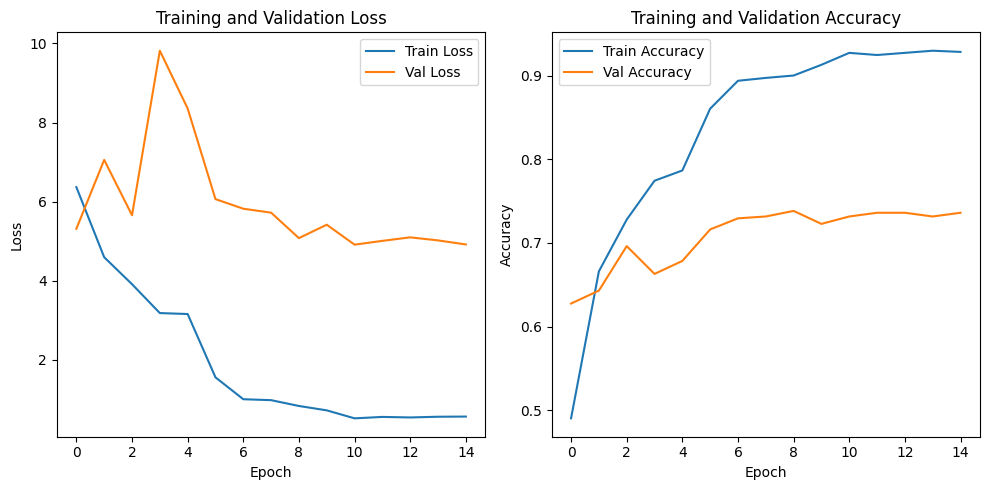

In [49]:
plot_training_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

eval

Test Accuracy: 0.6632


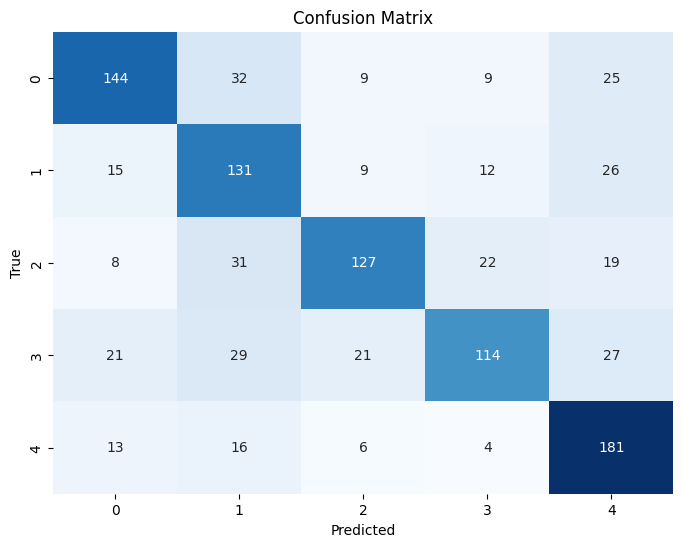

In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model_ft.eval()

predictions = []
true_labels = []
with torch.no_grad():
# Iterate over test loader
  for inputs, labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      # Forward pass
      outputs = model_ft(inputs)
      _, preds = torch.max(outputs, 1)

      # Append predictions and true labels
      predictions.extend(preds.cpu().numpy())
      true_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Test Accuracy: {accuracy:.4f}')

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def preprocess_image(image_path):
    """Load and preprocess an image."""
    # Define the transforms
    transform = transforms.Compose([
        transforms.Resize(384, interpolation=Image.BILINEAR),
        transforms.CenterCrop(384),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Apply the transforms
    image = transform(image)

    # Add batch dimension
    image = image.unsqueeze(0)

    return image

def predict_single_image(image_path, model, device):
    """Predict the class of a single image using the trained model."""
    # Preprocess the image
    image = preprocess_image(image_path)

    # Move the image to the device
    image = image.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Disable gradient computation
    with torch.no_grad():
        # Forward pass
        outputs = model(image)
        _, preds = torch.max(outputs, 1)

    return preds.item()

# Path to the image you want to test
image_path = 'path_to_your_image.jpg'

# Predict the class of the image
predicted_class = predict_single_image(image_path, model_ft, device)

# Print the predicted class
print(f'The predicted class for the image is: {predicted_class}')